# Covid-19 Dashboard
---

Analysis of Covid-19 cases based on data reported on the European CDC website. The data is updated once daily and can differ from other sources because the reporting times for each country is different. E.g. the UK figures are a day late.


Quick link to the [Dashboard](#dashboard)

---


**Modification history:**
- New ECDC file format supported
- Generic chart() function
- Metrics for cumulatives cases/deaths per million of population
- 3-day moving averages computed to smoothen fluctuations in daily cases/deaths
- Fatality7 metric computed on moving average stats instead of cumulative ones
- rpt_daily_stats() modified. Added a filter which defaults to only include countries when cum_deaths > 100
- Excel date format is a bit flaky about day-first vs. month-first - dates now generated using other fields
- Added consolidation at continent level
- Use dataframe styles for output; removed rounding

---

Chandranath Gunjal, 2020 (github.com/cdragun)

### Code <a id='code_section'></a>

In [1]:
import requests
import numpy as np
import pandas as pd

import IPython.display as ipd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style='whitegrid', context='notebook', palette='muted')

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 10)


In [2]:
# Fetch file and data cleaning

def fetch_ECDC_file(url1, url2):
    """Fetch file from ECDC website. Returns requests.response"""    
    # format can be .xlsx or .xls - try both
    r = requests.get(url1, allow_redirects=True)
    if r.ok:
        return r

    r = requests.get(url2, allow_redirects=True)
    return r


def load_data(asof, local_csv, url1, url2):
    """Read local csv or fetch from ECDC website"""
    try:
        # read local
        df = pd.read_csv(local_csv, parse_dates=[0], na_filter=False, index_col=False)

    except:
        # fetch data
        response = fetch_ECDC_file(url1, url2)
        if not response.ok:
            response.raise_for_status()

        # load into data frame using the response
        df = cleanse_ECDC_data(pd.read_excel(response.content, parse_dates=[0], na_filter=False))

        # save locally
        df.to_csv(local_csv, index=False)
    return df


def fix_missing_numeric(df, col, fillval=0):
    """Fill blanks and NAs with zeroes"""
    m = df[col].eq('')
    df.loc[m, col] = fillval
    df[col] = df[col].fillna(fillval)
    return
    
    
def cleanse_ECDC_data(df):
    """Cleanse and reformat ECDC data"""
    # work on a copy
    ndf = df.copy()
    
    # rename columns
    rv = {'countriesandterritories': 'country', 'popdata2019': 'population',
          'continentexp': 'continent', 'popdata2018': 'population'}
    c = [rv[k] if k in rv else k for k in (i.lower() for i in ndf.columns)]
    ndf.columns = c
    
    ndf['date'] = pd.to_datetime({'year': ndf['year'], 'month': ndf['month'], 'day': ndf['day']})
    needed_cols = ['date', 'country', 'geoid', 'cases', 'deaths', 'population', 'continent']
    ndf = pd.DataFrame(ndf, columns=needed_cols)

    # correct data for known issues
    fix_missing_numeric(ndf, 'population', 0)
    fix_missing_numeric(ndf, 'cases', 0)
    fix_missing_numeric(ndf, 'deaths', 0)
   
    # sort by country and date
    ndf.sort_values(by=['geoid', 'date'], ascending=[True, True],
                    axis=0, inplace=True, ignore_index=True)
    
    # append global totals
    ndf = ndf.append(compute_global_totals(ndf, 'W_'), ignore_index=True)

    # append cumulative counts
    ndf['cum_cases'] = ndf.groupby(['geoid'])['cases'].cumsum()
    ndf['cum_deaths'] = ndf.groupby(['geoid'])['deaths'].cumsum()
    return ndf



In [3]:
# Statistics / computations

def lookup_country(df, x):
    """Lookup a country name or geoid. Empty string prints full list"""
    x, n = x.upper(), len(x)
    all_names = dict(sorted(zip(df['geoid'], df['country'])))

    # simple search - either matches geoid or beginning of country name
    subset = {g:c for g,c in all_names.items() if x == g or x == c.upper()[:n]}
    
    # display
    for i, (g,c) in enumerate(subset.items(), 1):
        print('{: <26}'.format((g + ': ' + c)[:24]), end='')
        if i % 3 == 0: print()
    print()
    return


def compute_global_totals(df, prefix):
    """Return dataframe with by-continent and world-wide statistics"""
    if df['geoid'].str.startswith(prefix).any():
        raise ValueError('duplicate error: world stats already exist in dataframe')
        
    # consolidate by continent. Geoid = prefix + first two letters of continent name
    cc = df.groupby(['continent', 'date'], as_index=False).sum()
    cc['country'] = cc['continent']
    cc['geoid'] = prefix + cc['continent'].str[:2].str.upper()
   
    # worldwide numbers
    ww = df.groupby(['date'], as_index=False).sum()
    ww['country'] = 'World'
    ww['continent'] = 'World'
    ww['geoid'] = prefix + 'WW'
    return pd.concat([cc, ww])


def compute_fatality_ratio(df, lag, new_col, num_col='cum_deaths', denom_col='cum_cases'):
    """Compute fatality ratio with a given lag. Creates a new column in given df"""                    
    def shifted_fr(x):
        x[new_col] = (x[num_col] / x[denom_col].shift(lag)).fillna(0).replace(np.inf, 0)
        return x
        
    df[new_col] = df.groupby(['geoid']).apply(shifted_fr)[new_col]
    return


def compute_timeline(df, threshold, col, new_col):
    """Count days from when a variable crossed a given threshold. Creates a new column in df"""
    df[new_col] = 0
    df.loc[df[col] >= threshold, new_col] = 1
    df[new_col] = df.groupby(['geoid'])[new_col].cumsum()
    return


def compute_growth_rate(df, lag, col, new_col, dbl_col):
    """Compute average growth rate of a variable. Creates new columns in df"""
    def growth_rate(x):
        x[new_col] = (x[col] / x[col].shift(lag)).pow(1.0/lag).sub(1).\
                        fillna(0).replace(np.inf, 0)
        return x
    
    df[new_col] = df.groupby(['geoid']).apply(growth_rate)[new_col]
    df[dbl_col] = (np.log(2) / np.log(df[new_col].add(1))).\
                        fillna(0).replace(np.inf, 0)
    return


def compute_percapita_stat(df, col, new_col, base=1e6):
    """Rebase statistic to per unit of population"""
    df[new_col] = df[col].div(df['population']).mul(base).\
                        fillna(0).replace(np.inf, 0)
    return


def compute_ma(df, window, col, new_col):
    """Compute moving average of a given column"""
    df[new_col] = df.groupby(['geoid'])[col].apply(lambda s: s.rolling(window).mean()).\
                        fillna(0)
    return


def compute_stats(df, threshold=100, avg_period=3, lag=7):
    """Run all computations"""
    # Create a timeline - first day when cum_cases exceeded a threshold
    compute_timeline(df, threshold, 'cum_cases', 'timeline')

    # compute fatality ratios - both unlagged and lagged
    compute_fatality_ratio(df, 0, 'fatality0')

    # compute n-day growth rates and doubling times
    compute_growth_rate(df, avg_period, 'cum_cases', 'gr_cases', 'dbl_cases')
    compute_growth_rate(df, avg_period, 'cum_deaths', 'gr_deaths', 'dbl_deaths')
    
    # compute cum cases/deaths per million of population
    compute_percapita_stat(df, 'cum_cases', 'pm_cases', 1e6)
    compute_percapita_stat(df, 'cum_deaths', 'pm_deaths', 1e6)
    
    # moving average of daily cases / deaths
    compute_ma(df, avg_period, 'cases', 'ma_cases')
    compute_ma(df, avg_period, 'deaths', 'ma_deaths')
    compute_fatality_ratio(df, lag, 'fatality7', 'ma_deaths', 'ma_cases')

    # sort out column order
    df = pd.DataFrame(df, columns=['date', 'country', 'geoid', 'timeline',
                                   'continent', 'population',
                                   'cases', 'deaths', 'ma_cases', 'ma_deaths',
                                   'cum_cases', 'cum_deaths', 'pm_cases', 'pm_deaths',
                                   'fatality0','fatality7',
                                   'gr_cases', 'dbl_cases', 'gr_deaths', 'dbl_deaths'])
    return df


In [4]:
# Reports

nice_names = {'date': 'Date', 'country': 'Country', 'geoid': 'GeoId',
              'cases': 'Daily Cases', 'deaths': 'Daily Deaths',
              'population': 'Population',
              'cum_cases': 'Cum. Cases', 'cum_deaths': 'Cum. Deaths', 
              'timeline': 'Timeline',
              'fatality0': 'Fatality (spot)',   'fatality7': 'Fatality (lagged)',
              'gr_cases': 'Growth Rate Cases', 'gr_deaths': 'Growth Rate Deaths',
              'pm_cases': 'Cases (per mil.)',  'pm_deaths': 'Deaths (per mil.)',
              'ma_cases': 'MA Daily Cases',    'ma_deaths': 'MA Daily Deaths',
              'dbl_cases': 'Doubling Time Cases', 'dbl_deaths': 'Doubling Time Deaths'
             }


fmt_style = {'date': lambda d: d.strftime('%Y-%m-%d'), 'cases': '{:,.0f}', 'deaths': '{:,.0f}',
              'population': '{:,.0f}',
              'cum_cases': '{:,.0f}', 'cum_deaths': '{:,.0f}', 
              'fatality0': '{:.2%}',  'fatality7': '{:.2%}',
              'gr_cases': '{:.2%}',   'gr_deaths': '{:.2%}',
              'pm_cases': '{:,.0f}',  'pm_deaths': '{:,.0f}',
              'ma_cases': '{:,.0f}',  'ma_deaths': '{:,.0f}',
              'dbl_cases': '{:,.0f}', 'dbl_deaths': '{:,.0f}',
             }

def make_nice_names(names):
    """Return nice names for given list"""
    return [nice_names[c] if c in nice_names else c.capitalize() for c in names]


def spruce(df, show_cols=[], hide_cols=[], show_nice_names=False):
    """Spruce up index & columns for displaying a dataframe"""
    # choose columns to show
    all_cols = show_cols if len(show_cols) > 0 else list(df.columns)
    for c in hide_cols:
        if c in all_cols:
            all_cols.remove(c)
    
    y = pd.DataFrame(df, columns=all_cols)
 
    # pretty up index and columns names
    y.index = np.arange(1, len(df) + 1)
    if show_nice_names: y.columns = make_nice_names(all_cols)
    return y


def stylise(df, show_nice_names=False):
    """Apply styles to dataframe"""
    return df.style.format({nice_names[c]:f for c,f in fmt_style.items()}
                                if show_nice_names else fmt_style)
    
    
def rpt_show(df, caption, asof=None, sortby=None, count=0,
             hide_cols=['population'], show_nice_names=False):
    """Show part of a dataframe"""
    if count == 0: count = len(df)

    y = df
    if asof is not None: y = y[y.date == asof]
    if sortby is not None: y = y.sort_values([sortby], ascending=False)
    
    # show report 
    print('\n', caption, '\n')
    y = spruce(y.head(count), hide_cols=hide_cols, show_nice_names=show_nice_names)
    ipd.display(stylise(y, show_nice_names=show_nice_names))
    return


def rpt_daily_stats(df, asof, variables, filter_col='cum_deaths', threshold=100,
                    sort_ascending=False, count=10, show_nice_names=False):
    """Daily stats report"""
    main_cols = ['country', 'geoid']
    
    sections = []
    for i, v in enumerate(variables, 1):
        x = df[(df[filter_col] > threshold) & (df['date'] == asof) &
                      (~ df['geoid'].str.startswith('W_'))]\
                   .sort_values([v], ascending=sort_ascending)\
                   .head(count)
        
        x = spruce(x, main_cols + [v])
        x.columns = [c + str(i) for c in main_cols] + [v]
        sections.append(x)
    y = pd.concat(sections, axis=1)
    if show_nice_names: y.columns = make_nice_names(y.columns)

    print('\n', 'Daily statistics for ' + asof, '\n')
    ipd.display(stylise(y, show_nice_names=show_nice_names))
    return


def rpt_history(df_all, geoid, history=7, show_nice_names=False):
    """Show n-day history for given geoid"""
    
    # show history
    df = df_all[(df_all.geoid == geoid) & (df_all.timeline > 0)]
    if len(df) < 2:
        print("Insufficient data for requested country")
        return
    
    caption = '{} ({}), pop. {:,}: Last {} days. Timeline: Day-{}'.\
               format(df['country'].iloc[0], geoid, df['population'].max(),
                      history, df['timeline'].max())
    rpt_show(df.tail(history)[::-1], caption, hide_cols=['country', 'geoid',
                                                         'population', 'continent'],
            show_nice_names=show_nice_names)
    return


def rpt_country(df_all, geoid, history=7, show_nice_names=False):
    """Summary report for given country"""
    
    # show history
    rpt_history(df_all, geoid, history, show_nice_names=show_nice_names)

    # show charts
    df = df_all[(df_all.geoid == geoid) & (df_all.timeline > 0)]
    if len(df) < 2:
        print("Insufficient data for requested country")
        return None
  
    plt.figure(1, figsize=(18, 21))
    ax = plt.subplot(321)
    df.plot(ax=ax, x='timeline', y=['cum_cases'], marker='.')

    ax = plt.subplot(322)
    df.plot(ax=ax, x='timeline', y=['cum_deaths'], marker='.')

    ax = plt.subplot(323)
    # df.plot(ax=ax, x='timeline', y=['cases', 'ma_cases', 'gr_cases'],
    #        secondary_y='gr_cases', marker='.')
    df.plot(ax=ax, x='timeline', y='cases', kind='line')
    # df.plot(ax=ax, x='timeline', y='ma_cases', kind='line')
    df.plot(ax=ax, x='timeline', y='gr_cases', secondary_y='gr_cases', kind='line', marker='.')
    
    ax = plt.subplot(324)
    # df.plot(ax=ax, x='timeline', y=['deaths', 'ma_deaths', 'gr_deaths'],
    #        secondary_y='gr_deaths', marker='.')
    df.plot(ax=ax, x='timeline', y='deaths', kind='line')
    # df.plot(ax=ax, x='timeline', y='ma_deaths', kind='line')
    df.plot(ax=ax, x='timeline', y='gr_deaths', secondary_y='gr_deaths', kind='line', marker='.')

    ax = plt.subplot(325)
    df.plot(ax=ax, x='timeline', y=['fatality0', 'fatality7'], marker='.')

    ax = plt.subplot(326)
    df.plot(ax=ax, x='timeline', y=['dbl_cases', 'dbl_deaths'], marker='.')

    plt.show()
    return


In [5]:
# charts
def chart(df, title, *, geoid, x, y, log_scale=None, filter_timeline=False,
          figsize=(16,8), **kwargs):
    """Generic charting routine
    
    geoid:           a single geoid or a list
    x:               x-axis column
    y:               y-axis column(s)
    log_scale:       scale axis on a log scale; valid values are None, x, y or both
    filter_timeline: additionally filter data for timeline > 0
    
    Note that both geoid and y cannot be lists.
    """
    # check parameters
    if np.isscalar(geoid):
        geoid = [geoid]
    if np.isscalar(y):
        y = [y]
    assert len(geoid) == 1 or len(y) == 1, 'Both geoid and y cannot be arraylike'
    
    # log graph?
    p_logx = log_scale == 'x'
    p_logy = log_scale == 'y'
    p_loglog = log_scale == 'both'

    # filter data
    mask = df['geoid'].isin(geoid)
    if x == 'timeline' or filter_timeline:
        mask &= df['timeline'] > 0

    needed_cols = [x] + y
    cnames = dict(zip(df['geoid'], df['country']))   # TODO: Refactor

    # create the chart
    plt.figure(1, figsize=figsize)
    ax = plt.subplot(111)
    for g in geoid:
        lbl = y if len(geoid) == 1 else [cnames.get(g, g)]
        
        data = pd.DataFrame(df[mask & (df['geoid'] == g)], columns=needed_cols)
        data.plot(ax=ax, x=x, y=y, label=lbl, logx=p_logx, logy=p_logy, loglog=p_loglog, **kwargs)

    plt.title(title)
    plt.show()
    return


def timeline_chart(df, title, *, geoid, y, log_scale=None, **kwargs):
    """Chart variable for given countries"""
    chart(df, title, geoid=geoid, x='timeline', y=y, log_scale=log_scale, **kwargs)
    return


### Dashboard <a id='dashboard'></a>

- Update asof to today's date and load data
- This will fetch the data from the ECDC website and save a clean (dated) version in the local directory
- Subsequent loads will read the local version if it exists.


Click here to go to the [Code section](#code_section)

In [6]:
# general parameters
# ------------------
# asof date
asof = '2020-12-14'

# Day0 for each country is determined when cum_cases >= threshold
timeline_threshold = 100

# Period over which to compute the average growth rate
avg_period = 3

# subsets of interest
home = 'UK'
world = 'W_WW'
monitor = ['W_WW', 'US', 'BR', 'UK', 'IT', 'ES', 'DE', 'FR', 'CH', 'SE',
           'CN', 'JP', 'KR', 'RU', 'IN']
continents = ['W_WW', 'W_AS', 'W_EU', 'W_AM', 'W_AF', 'W_OC', 'W_OT']

# load and compute data
# ---------------------
# ECDC website - caveat, the file's name format changes once in a while
site = 'https://www.ecdc.europa.eu/sites/default/files/documents/'
url1 = site + 'COVID-19-geographic-disbtribution-worldwide-' + asof + '.xlsx'
url2 = site + 'COVID-19-geographic-disbtribution-worldwide-' + asof + '.xls'

# Local filename - the cleaned data is saved here. If this file exists, the routine
# will load it instead of hitting the ECDC website
local_csv = 'ecdc_' + asof.replace('-', '') + '.csv'
df = load_data(asof, local_csv, url1, url2)
df = compute_stats(df, timeline_threshold, avg_period)

# data subsets 
df_world = df[df['geoid'] == world]
df_home  = df[df['geoid'] == home]
df_mon   = df[df['geoid'].isin(monitor)]
df_continents = df[df['geoid'].isin(continents)]


In [7]:
# export computed dataframe if needed
# df.to_csv('cvdb_' + asof.replace('-', '') + '.csv')


### Description of column names
---
- *geoid:* Geographic ID. WW has been included for World statistics
- *timeline:* Day-1 is the first day that cum_cases for a country exceeds a certain threshold (defined by timeline_threshold; see above)


- *cases:* Cases reported on the given date
- *cum_cases:* Cumulative cases up to the given date
- *deaths:* Deaths reported on the given date
- *cum_deaths:* Cumulative deaths up to the given date


- *fatality0:* Spot fatality rate (%age) based on cumulative statistics. FR0 = cum_deaths(t) / cum_cases(t)
- *fatality7:* Lagged fatality rate based on moving average statistics. FR7 = ma_deaths(t) / ma_cases(t-7)


- *gr_cases:* The growth rate (%age) in cases reported. This is a 3-day compounded moving average to smoothen the data
- *gr_deaths:* The growth rate (%age) in deaths reported. Computed similar to gr_cases
- *dbl_cases:* Days for cumulative cases reported to double in number. Implied from the growth rate; therefore lagging because of the averaging period used
- *dbl_deaths:* Days for cumulative deaths reported to double in number


- *pm_cases:* Total cases per million of population
- *pm_deaths:* Total deaths per million of population
- *ma_cases:* 3-day moving average of daily cases reported
- *ma_deaths:* 3-day moving average of daily deaths reported

---

### Monitor

Statistics for countries in the monitor list 

In [8]:
rpt_show(df_continents, 'Statistics by continent for: ' + asof, asof, 'cum_deaths',
         hide_cols=['population', 'date', 'geoid', 'continent'], show_nice_names=True)


 Statistics by continent for: 2020-12-14 



,Country,Timeline,Daily Cases,Daily Deaths,MA Daily Cases,MA Daily Deaths,Cum. Cases,Cum. Deaths,Cases (per mil.),Deaths (per mil.),Fatality (spot),Fatality (lagged),Growth Rate Cases,Doubling Time Cases,Growth Rate Deaths,Doubling Time Deaths
1,World,331,"540,659","7,085","608,073","9,898","71,503,614","1,612,833","9,380",212,2.26%,1.59%,0.87%,80,0.62%,112
2,America,289,"250,922","2,433","298,430","4,036","30,887,593","785,420","30,473",775,2.54%,1.40%,0.99%,71,0.52%,134
3,Europe,296,"208,571","3,277","221,859","4,399","21,400,012","479,789","26,707",599,2.24%,1.86%,1.06%,66,0.93%,75
4,Asia,331,"64,995","1,027","69,856","1,106","16,782,046","290,129","3,763",65,1.73%,1.37%,0.42%,165,0.38%,181
5,Africa,279,"16,142",347,"17,856",356,"2,379,827","56,334","1,821",43,2.37%,2.27%,0.76%,91,0.64%,109
6,Oceania,280,29,1,72,1,"53,440","1,154","1,289",28,2.16%,0.81%,0.13%,516,0.12%,599


In [9]:
rpt_show(df_mon, 'Statistics by country for: ' + asof, asof, 'cum_deaths',
         hide_cols=['population', 'date', 'geoid', 'continent'], show_nice_names=False)


 Statistics by country for: 2020-12-14 



,country,timeline,cases,deaths,ma_cases,ma_deaths,cum_cases,cum_deaths,pm_cases,pm_deaths,fatality0,fatality7,gr_cases,dbl_cases,gr_deaths,dbl_deaths
1,World,331,"540,659","7,085","608,073","9,898","71,503,614","1,612,833","9,380",212,2.26%,1.59%,0.87%,80,0.62%,112
2,United_States_of_America,287,"189,723","1,340","213,458","2,333","16,256,754","299,177","49,403",909,1.84%,1.13%,1.35%,52,0.79%,88
3,Brazil,275,"21,825",279,"40,051",546,"6,901,952","181,402","32,703",860,2.63%,1.41%,0.59%,118,0.30%,229
4,India,273,"27,071",336,"29,110",390,"9,884,100","143,355","7,234",105,1.45%,1.11%,0.30%,234,0.27%,254
5,Italy,295,"17,937",484,"18,855",631,"1,843,712","64,520","30,545","1,069",3.50%,2.96%,1.04%,67,1.00%,70
6,United_Kingdom,286,"18,447",144,"20,540",363,"1,849,403","64,170","27,749",963,3.47%,2.22%,1.14%,61,0.57%,122
7,France,289,"11,533",150,"12,962",324,"2,376,852","57,911","35,469",864,2.44%,2.76%,0.55%,126,0.57%,123
8,Russia,272,"28,080",488,"28,267",554,"2,653,928","46,941","18,194",322,1.77%,1.95%,1.09%,64,1.21%,58
9,Germany,289,"16,362",188,"21,667",335,"1,337,078","21,975","16,106",265,1.64%,1.88%,1.68%,42,1.57%,44
10,Sweden,283,0,0,0,0,"320,098","7,514","31,290",734,2.35%,0.00%,0.00%,0,0.00%,0


### Country Report

Show recent history and charts for a given country (or the world 'WW')

In [10]:
# find country - empty string prints full list
# lookup_country(df, 'Taiwan')
# rpt_history(df, 'UK', history=60)


 United_Kingdom (UK), pop. 66,647,112: Last 7 days. Timeline: Day-286 



,date,timeline,cases,deaths,ma_cases,ma_deaths,cum_cases,cum_deaths,pm_cases,pm_deaths,fatality0,fatality7,gr_cases,dbl_cases,gr_deaths,dbl_deaths
1,2020-12-14,286,"18,447",144,"20,540",363,"1,849,403","64,170","27,749",963,3.47%,2.22%,1.14%,61,0.57%,122
2,2020-12-13,285,"21,501",520,"21,379",487,"1,830,956","64,026","27,472",961,3.50%,3.13%,1.20%,58,0.77%,90
3,2020-12-12,284,"21,672",424,"19,738",491,"1,809,455","63,506","27,150",953,3.51%,3.11%,1.12%,62,0.79%,89
4,2020-12-11,283,"20,964",516,"16,608",549,"1,787,783","63,082","26,825",947,3.53%,3.71%,0.95%,74,0.89%,79
5,2020-12-10,282,"16,578",533,"14,526",440,"1,766,819","62,566","26,510",939,3.54%,3.15%,0.84%,83,0.71%,97
6,2020-12-09,281,"12,281",599,"14,757",340,"1,750,241","62,033","26,261",931,3.54%,2.69%,0.86%,81,0.55%,126
7,2020-12-08,280,"14,718",189,"15,843",272,"1,737,960","61,434","26,077",922,3.53%,2.02%,0.93%,75,0.45%,155


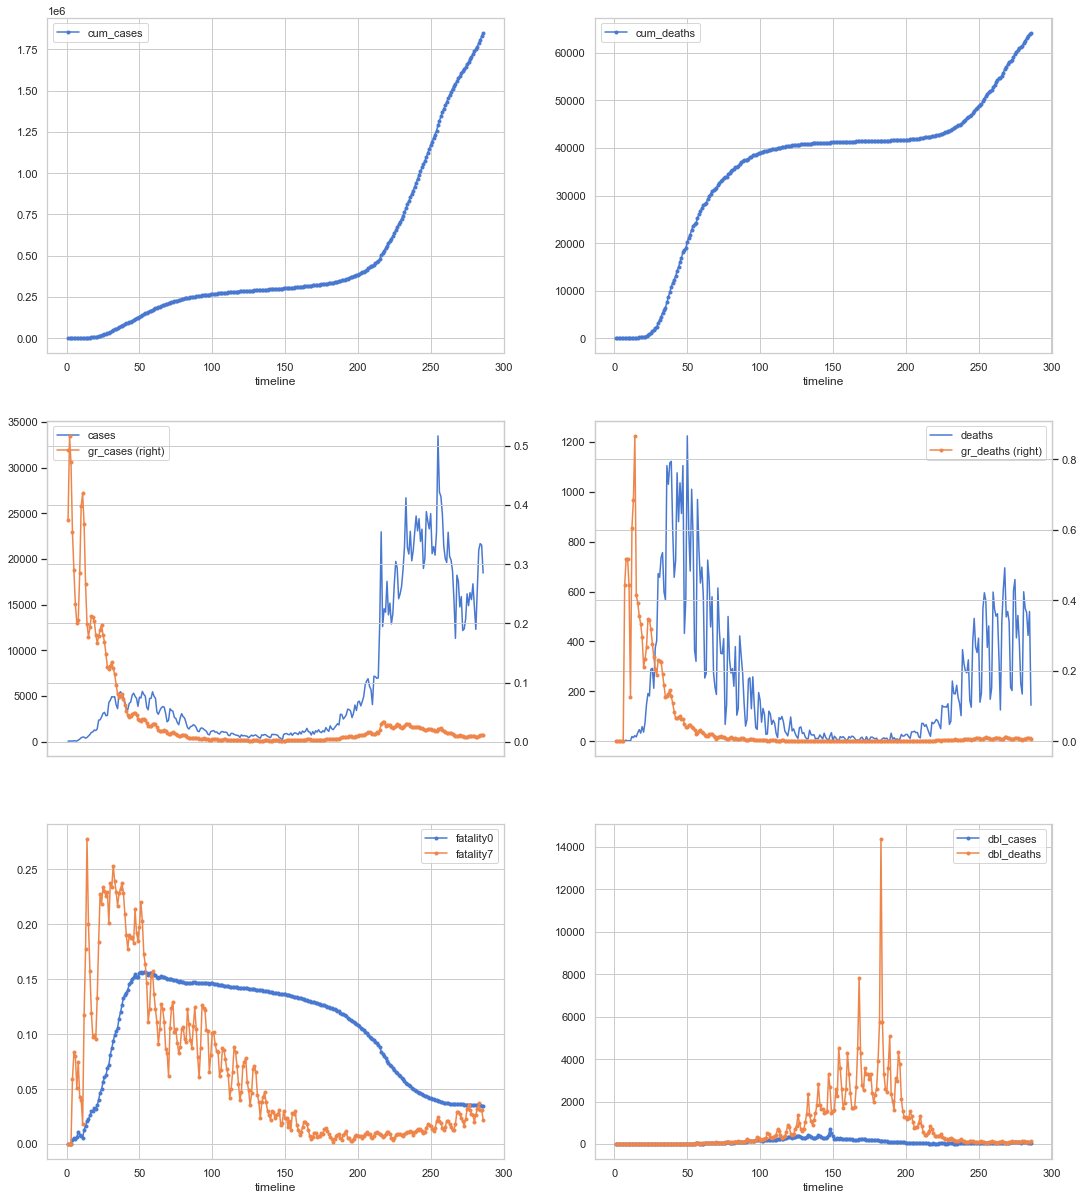

In [11]:
rpt_country(df, 'UK', history=7)

### Daily Rankings

Daily rankings by variable. By default, countries included iff cum_deaths > 100.

In [12]:
rpt_daily_stats(df, asof, ['cases', 'deaths', 'cum_cases', 'cum_deaths'], show_nice_names=True)


 Daily statistics for 2020-12-14 



,Country1,Geoid1,Daily Cases,Country2,Geoid2,Daily Deaths,Country3,Geoid3,Cum. Cases,Country4,Geoid4,Cum. Deaths
1,United_States_of_America,US,"189,723",United_States_of_America,US,"1,340",United_States_of_America,US,"16,256,754",United_States_of_America,US,"299,177"
2,Turkey,TR,"29,136",Russia,RU,488,India,IN,"9,884,100",Brazil,BR,"181,402"
3,Russia,RU,"28,080",Italy,IT,484,Brazil,BR,"6,901,952",India,IN,"143,355"
4,India,IN,"27,071",India,IN,336,Russia,RU,"2,653,928",Mexico,MX,"113,953"
5,Brazil,BR,"21,825",Brazil,BR,279,France,FR,"2,376,852",Italy,IT,"64,520"
6,United_Kingdom,UK,"18,447",Ukraine,UA,249,United_Kingdom,UK,"1,849,403",United_Kingdom,UK,"64,170"
7,Italy,IT,"17,937",Mexico,MX,249,Italy,IT,"1,843,712",France,FR,"57,911"
8,Germany,DE,"16,362",Iran,IR,247,Argentina,AR,"1,498,160",Iran,IR,"52,196"
9,Ukraine,UA,"15,627",Turkey,TR,222,Colombia,CO,"1,425,774",Russia,RU,"46,941"
10,France,FR,"11,533",Poland,PL,188,Germany,DE,"1,337,078",Argentina,AR,"40,766"


In [13]:
rpt_daily_stats(df, asof, ['pm_cases', 'pm_deaths', 'gr_cases', 'gr_deaths'], show_nice_names=True)


 Daily statistics for 2020-12-14 



,Country1,Geoid1,Cases (per mil.),Country2,Geoid2,Deaths (per mil.),Country3,Geoid3,Growth Rate Cases,Country4,Geoid4,Growth Rate Deaths
1,Luxembourg,LU,"67,230",Belgium,BE,"1,567",Lithuania,LT,3.00%,Latvia,LV,4.71%
2,Montenegro,ME,"66,582",Peru,PE,"1,128",Denmark,DK,2.98%,Croatia,HR,2.94%
3,Czechia,CZ,"54,562",Italy,IT,"1,069",Estonia,EE,2.84%,Syria,SY,2.86%
4,Bahrain,BH,"54,317",North_Macedonia,MK,"1,021",Latvia,LV,2.70%,Georgia,GE,2.78%
5,Belgium,BE,"53,075",Bosnia_and_Herzegovina,BA,"1,011",Azerbaijan,AZ,2.61%,Lithuania,LT,2.59%
6,Armenia,AM,"50,269",United_Kingdom,UK,963,Croatia,HR,2.36%,Hungary,HU,2.49%
7,Qatar,QA,"49,773",Montenegro,ME,935,Sri_Lanka,LK,2.32%,Greece,EL,2.46%
8,United_States_of_America,US,"49,403",Argentina,AR,910,Uganda,UG,2.28%,Serbia,RS,2.38%
9,Georgia,GE,"47,804",United_States_of_America,US,909,Serbia,RS,2.25%,Luxembourg,LU,2.38%
10,Slovenia,SI,"46,285",Czechia,CZ,902,South_Korea,KR,2.16%,Azerbaijan,AZ,2.34%


In [14]:
rpt_daily_stats(df, asof, ['fatality0', 'fatality7'], show_nice_names=True)


 Daily statistics for 2020-12-14 



,Country1,Geoid1,Fatality (spot),Country2,Geoid2,Fatality (lagged)
1,Yemen,YE,29.09%,Syria,SY,16.41%
2,Mexico,MX,9.12%,Malawi,MW,12.50%
3,Ecuador,EC,6.87%,Greece,EL,6.48%
4,Sudan,SD,6.30%,Saudi_Arabia,SA,5.89%
5,Bolivia,BO,6.13%,Mexico,MX,5.21%
6,Chad,TD,5.76%,Guatemala,GT,5.21%
7,Egypt,EG,5.69%,Egypt,EG,5.17%
8,Syria,SY,5.65%,Angola,AO,5.14%
9,China,CN,5.15%,Guam,GU,4.84%
10,Iran,IR,4.71%,Bosnia_and_Herzegovina,BA,4.62%


### Timeline Charts

Cumulatives cases and deaths against the timeline for each country. Day 1 on the timeline is the first day when total cases exceeds 100

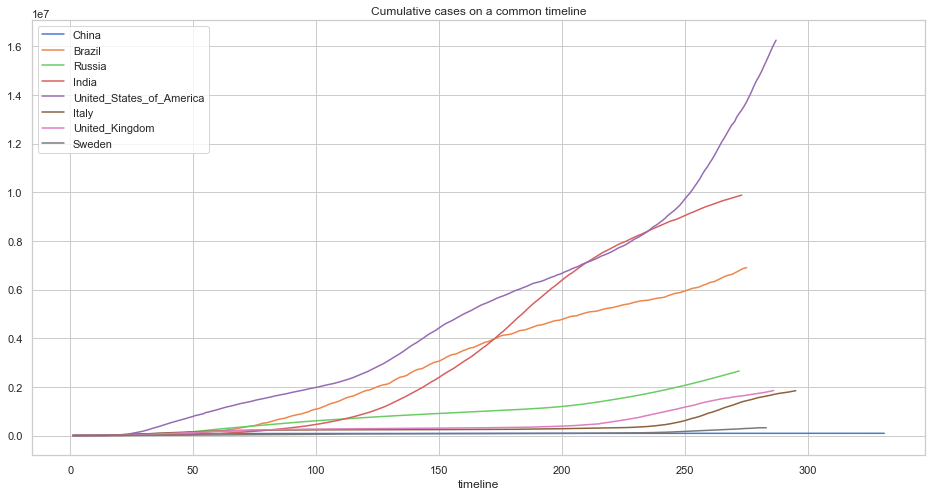

In [15]:
g_list = ['CN', 'BR', 'RU', 'IN', 'US', 'IT', 'UK', 'SE']
#g_list = ['DK', 'FI', 'NO', 'NL', 'SE']
timeline_chart(df, 'Cumulative cases on a common timeline',
               geoid=g_list, y='cum_cases', log_scale='')

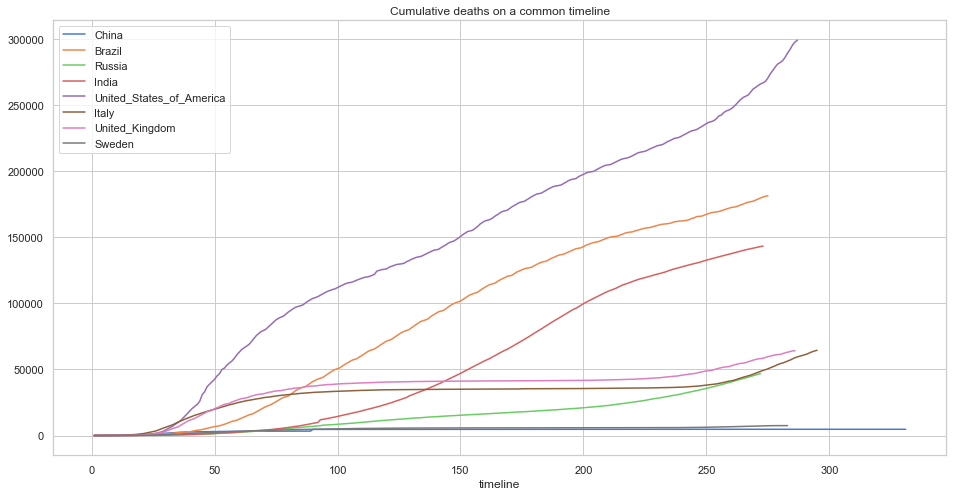

In [16]:
timeline_chart(df, 'Cumulative deaths on a common timeline',
               geoid=g_list, y='cum_deaths', log_scale='', marker='')

### Quick chart

Generic chart to quickly plot different variables


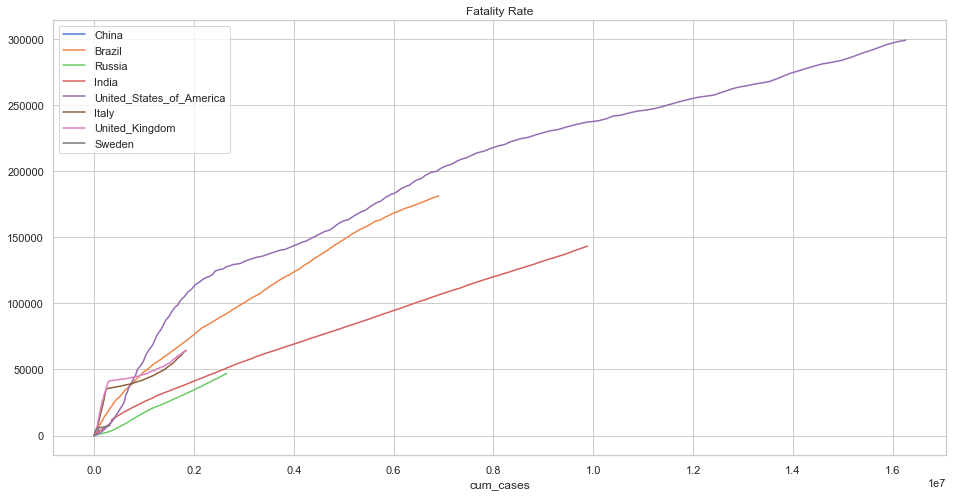

In [17]:
chart(df, 'Fatality Rate', geoid=g_list, x='cum_cases', y='cum_deaths',
#chart(df, 'Quick', geoid='UK', x='timeline', y='deaths',
      log_scale='', filter_timeline=True, marker='')

### Inflection point - Where does the plateau start?

Monitor the  daily cases / deaths against the China timeline. 

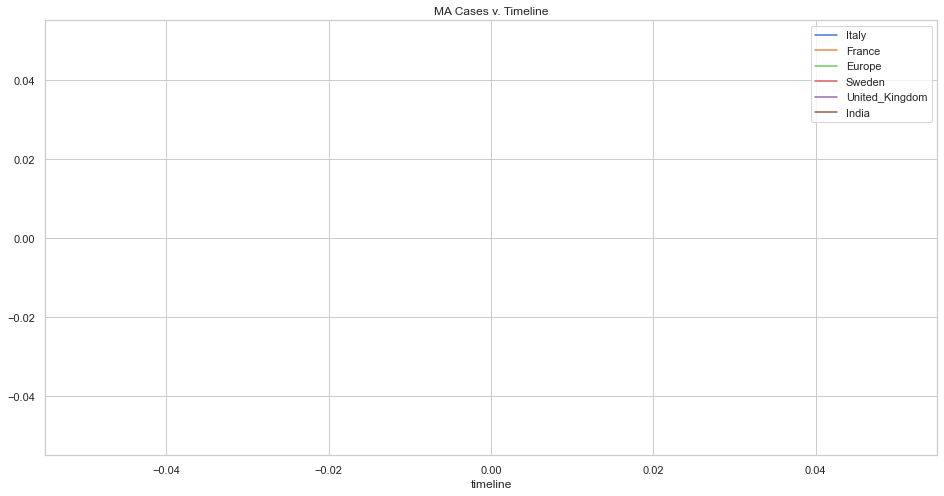

In [18]:
g2_list = ['IT', 'FR', 'W_EU','SE', 'UK', 'IN']
chart(df, 'MA Cases v. Timeline', geoid=g2_list, x='timeline', y='std_deaths',
      log_scale='', filter_timeline=True, marker='')

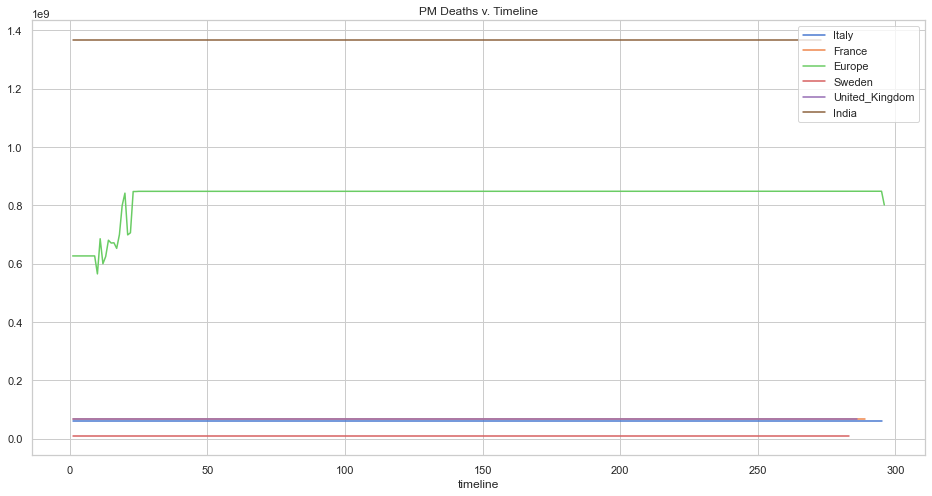

In [22]:
chart(df, 'PM Deaths v. Timeline', geoid=g2_list , x='timeline', y='population',
      log_scale='', filter_timeline=True, marker='')

In [20]:
# Normalise by population size
# df['std_deaths'] = df['ma_deaths'] / df['population']
# df['std_cases'] = df['ma_cases'] / df['population']